In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [4]:
# Directory containing the dataset
DATASET_DIR = r"C:\\Users\\hassa\\OneDrive\\Desktop\\pest project\\Dataset"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Print class names before prefetching
class_names = train_ds.class_names
print(f"Class names: {class_names}")

# Prefetch datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 40347 files belonging to 6 classes.
Using 32278 files for training.
Found 40347 files belonging to 6 classes.
Using 8069 files for validation.
Class names: ['Disease_Leaf_Blight_Dorsal', 'Disease_Leaf_Blight_Ventral', 'Disease_Mosaic_Dorsal', 'Disease_Mosaic_Ventral', 'Healthy_Dorsal', 'Healthy_Ventral']


In [22]:
# Define the model
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model

# Class names already available
class_names = ['Disease_Leaf_Blight_Dorsal', 'Disease_Leaf_Blight_Ventral', 'Disease_Mosaic_Dorsal', 'Disease_Mosaic_Ventral', 'Healthy_Dorsal', 'Healthy_Ventral']

# Define the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Use len(class_names) here
])



In [24]:

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [25]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]


In [26]:

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)



Epoch 1/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 767s 755ms/step - accuracy: 0.7008 - loss: 0.8296 - val_accuracy: 0.9170 - val_loss: 0.2360
Epoch 2/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 745s 738ms/step - accuracy: 0.8971 - loss: 0.2951 - val_accuracy: 0.9515 - val_loss: 0.1410
Epoch 3/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 698s 692ms/step - accuracy: 0.9218 - loss: 0.2232 - val_accuracy: 0.9554 - val_loss: 0.1316
Epoch 4/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 693s 686ms/step - accuracy: 0.9329 - loss: 0.1820 - val_accuracy: 0.9648 - val_loss: 0.1001
Epoch 5/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 649s 643ms/step - accuracy: 0.9405 - loss: 0.1643 - val_accuracy: 0.9667 - val_loss: 0.0913
Epoch 6/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 650s 644ms/step - accuracy: 0.9465 - loss: 0.1470 - val_accuracy: 0.9781 - val_loss: 0.0690
Epoch 7/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 709s 702ms/step - accuracy: 0.9515 - loss: 0.1320 - val_accuracy: 0.9698 - val_loss: 0.0831
Epoch 8/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 671s 665ms/step - ac

In [27]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

253/253 ━━━━━━━━━━━━━━━━━━━━ 140s 551ms/step - accuracy: 0.9914 - loss: 0.0310
Validation Accuracy: 99.01%


In [29]:

# Save the model
model.save("resnet50_final_model.keras")

In [33]:

# Classification Report
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=-1)

class_names = ['Disease_Leaf_Blight_Dorsal', 'Disease_Leaf_Blight_Ventral', 'Disease_Mosaic_Dorsal', 'Disease_Mosaic_Ventral', 'Healthy_Dorsal', 'Healthy_Ventral']

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

253/253 ━━━━━━━━━━━━━━━━━━━━ 142s 561ms/step

Classification Report:
                             precision    recall  f1-score   support

 Disease_Leaf_Blight_Dorsal       0.12      0.12      0.12      1054
Disease_Leaf_Blight_Ventral       0.22      0.22      0.22      1875
      Disease_Mosaic_Dorsal       0.05      0.05      0.05       560
     Disease_Mosaic_Ventral       0.35      0.36      0.35      2840
             Healthy_Dorsal       0.06      0.06      0.06       550
            Healthy_Ventral       0.14      0.14      0.14      1190

                   accuracy                           0.22      8069
                  macro avg       0.16      0.16      0.16      8069
               weighted avg       0.22      0.22      0.22      8069



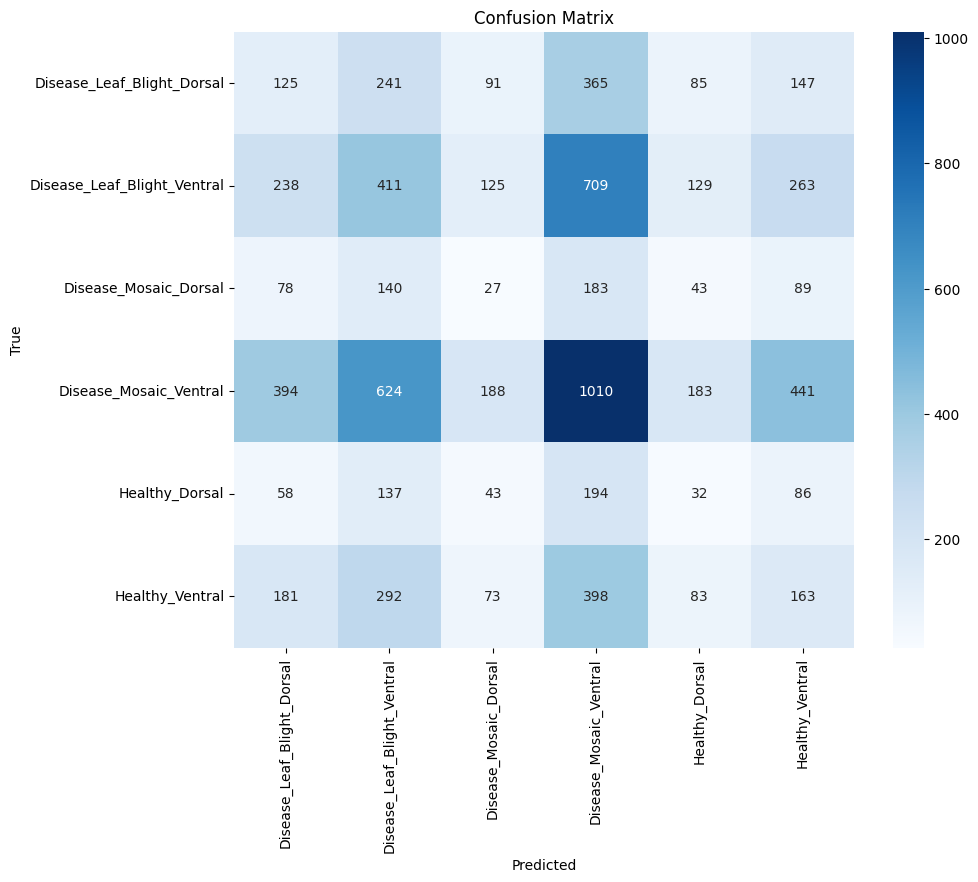

In [42]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('Resnet50 Confusion Matrix.jpg')
plt.show()

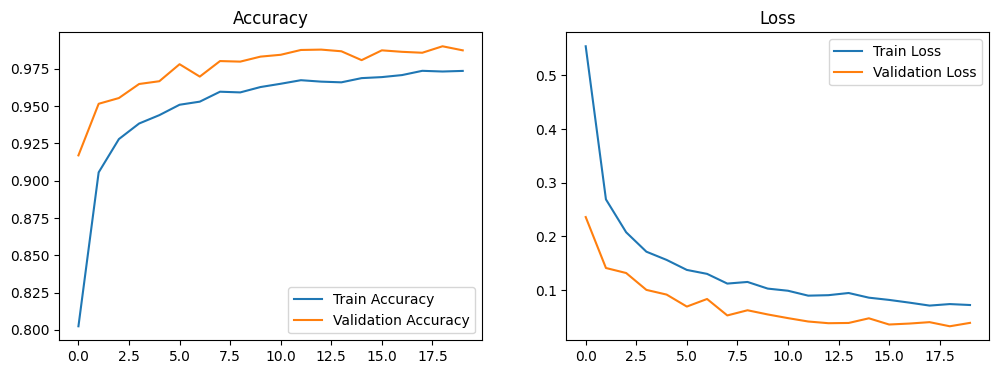

In [41]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")
plt.savefig('resnet50 training.jpg')
plt.show()


In [7]:
import tensorflow as tf

# Reload the dataset
DATASET_DIR = r"C:\Users\hassa\OneDrive\Desktop\pest project\Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")


Found 40347 files belonging to 6 classes.
Using 32278 files for training.
Found 40347 files belonging to 6 classes.
Using 8069 files for validation.
Class names: ['Disease_Leaf_Blight_Dorsal', 'Disease_Leaf_Blight_Ventral', 'Disease_Mosaic_Dorsal', 'Disease_Mosaic_Ventral', 'Healthy_Dorsal', 'Healthy_Ventral']


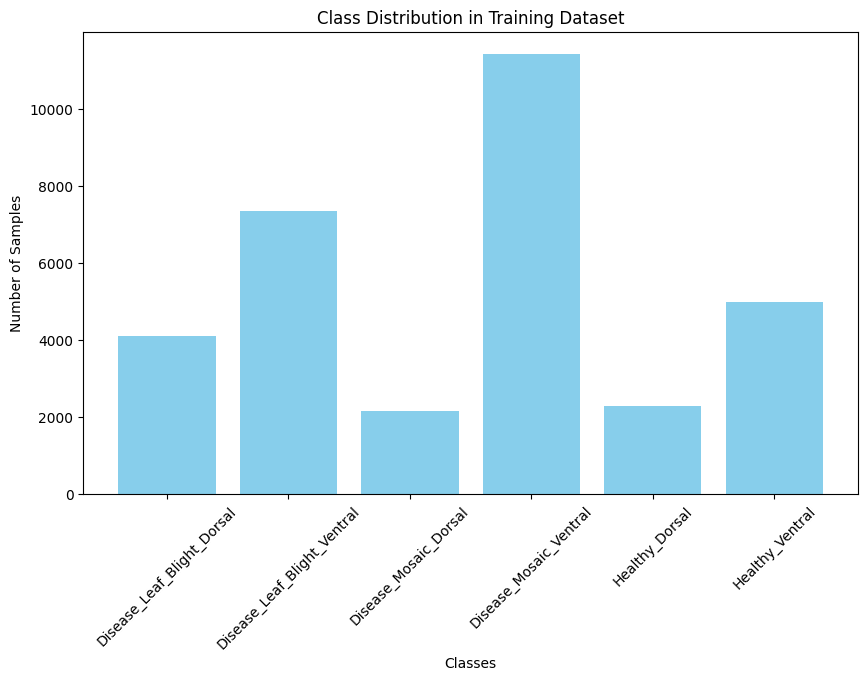

In [12]:
import matplotlib.pyplot as plt

# Count the number of samples in each class
class_counts = {class_name: 0 for class_name in class_names}

for images, labels in train_ds.unbatch():
    class_counts[class_names[labels.numpy()]] += 1

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.savefig('resnet :number of samples in each class')
plt.show()


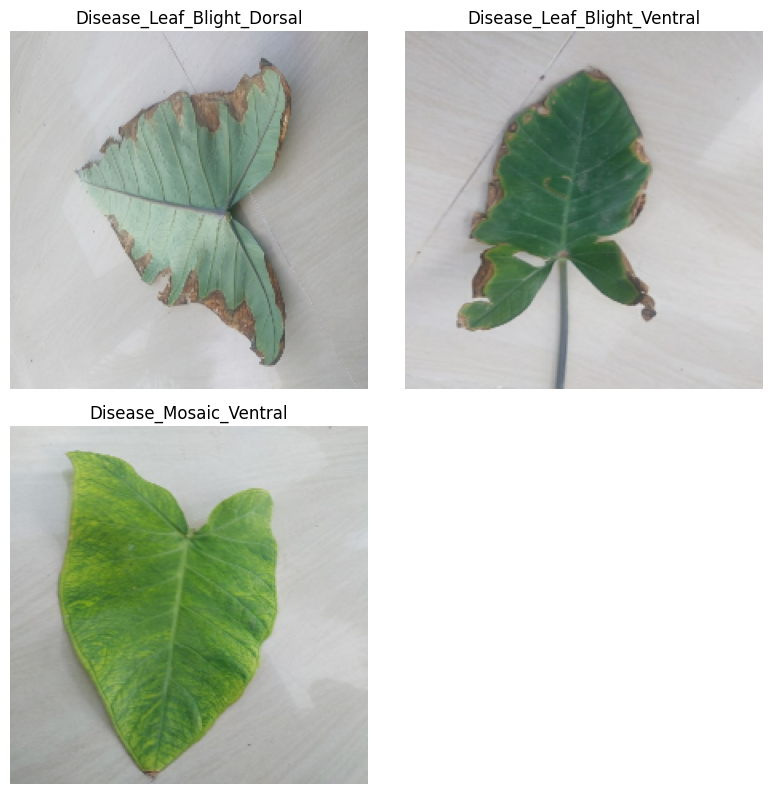

In [11]:
import numpy as np

# Display random images from each class
plt.figure(figsize=(12, 12))
for i, class_name in enumerate(class_names):
    for images, labels in train_ds.unbatch().take(3):
        if class_names[labels.numpy()] == class_name:
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images.numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")
plt.tight_layout()
plt.savefig('resnet50 random images.jpg')
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Extract features and labels from the dataset
features = []
labels = []

for images, label_batch in train_ds.take(100):  # Limit for visualization
    features.append(images.numpy().reshape(len(images), -1))
    labels.extend(label_batch.numpy())

features = np.concatenate(features, axis=0)
labels = np.array(labels)

# Apply t-SNE
tsne = TSNE(n_components=3, random_state=42)
reduced_features = tsne.fit_transform(features)

# Create a DataFrame for easier plotting
df = pd.DataFrame(reduced_features, columns=["x", "y", "z"])
df["label"] = labels

# Plot 3D t-SNE
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df["x"], df["y"], df["z"], c=df["label"], cmap='viridis')
legend = ax.legend(
    [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=10)],
    ["Class Labels"], loc="upper right")
plt.title("t-SNE 3D Visualization of Feature Space")
plt.savefig('resnet: t-SNE 3D Visualization of Feature Space')
plt.show()
